In [1]:
import pandas as pd
import numpy as np
import xgboost
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
i_train = pd.read_csv('../data/acc_data/training_large_lag_5.csv', sep = '\t')#,header = None)
i_test = pd.read_csv('../data/acc_data/validation_large_lag_5.csv', sep = '\t')#,header = None)

In [3]:
train = i_train.loc[200:].append(i_test.loc[:200]).reset_index(drop = True)
test = i_train.loc[:200].append(i_test.loc[200:]).reset_index(drop = True)

In [4]:
train.head()

,id,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,...,vy_lag_1,vy_lag_2,vy_lag_3,vy_lag_4,vy_lag_5,vz_lag_1,vz_lag_2,vz_lag_3,vz_lag_4,vz_lag_5
0,1,0.0,0.0,0.0,11.045761,-0.300808,-0.010405,-0.000802,-0.000246,-0.067718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,11.045767,-0.300907,-0.020017,-0.001542,-0.000472,-0.095638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,11.045745,-0.300835,-0.032035,-0.002468,-0.000759,-0.119570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,11.045697,-0.300881,-0.046057,-0.003549,-0.001091,-0.139515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,11.045741,-0.300799,-0.061682,-0.004753,-0.001455,-0.155475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X = train.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels',
                 'vx_lag_1','vx_lag_2', 'vx_lag_3', 'vx_lag_4', 'vx_lag_5', 'vy_lag_1', 'vy_lag_2',
                 'vy_lag_3','vy_lag_4', 'vy_lag_5', 'vz_lag_1', 'vz_lag_2', 'vz_lag_3','vz_lag_4', 'vz_lag_5']]
Y_ax = train.loc[:,['ax']].values.ravel() # flatten to 1d array
Y_ay = train.loc[:,['ay']].values.ravel()

# y = Y_ax
X_train_ax, X_test_ax, y_train_ax, y_test_ax = train_test_split(X, Y_ax)
X_train_ay, X_test_ay, y_train_ay, y_test_ay = train_test_split(X, Y_ay)

In [7]:
model_XGB = make_pipeline(StandardScaler(), xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3,
                                            n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85))
print(' Extreme Gradient Boosting score for ax is: ' ,-np.mean(cross_val_score(model_XGB,X_train_ax,y_train_ax, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')

 Extreme Gradient Boosting score for ax is:  0.07695091115943535 



In [8]:
model_XGB = make_pipeline(StandardScaler(), xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3,
                                            n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85))
print(' Extreme Gradient Boosting score for ay is: ' ,-np.mean(cross_val_score(model_XGB,X_train_ay,y_train_ay, scoring='neg_median_absolute_error', cv = 5, n_jobs = -1)),'\n')

 Extreme Gradient Boosting score for ay is:  0.07418003740775303 



In [9]:
def stacking_model(X_train,y_train):
    
    lasso = Lasso(alpha = 1e-3)
    GBC = GradientBoostingRegressor(alpha = 0.85,n_estimators = 1000,max_depth = 3)
    LGB = LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=800)
    XGB = xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3, n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85)

    categorical = X_train.dtypes == object
    model_SR = make_pipeline(RobustScaler(), StackingRegressor(regressors=[LGB,lasso,XGB], meta_regressor=lasso))

    scores = cross_val_score(model_SR, X_train, y_train, scoring='neg_median_absolute_error',cv=5, n_jobs = -1)
    print("Stacking Regressor score: ", -scores.mean(), ' std: ', scores.std())
    
    return model_SR

In [10]:
model_SR = stacking_model(X_train_ax,y_train_ax)

Stacking Regressor score:  0.05705686970389144  std:  0.0008650825628497624


In [11]:
model_SR_ay = stacking_model(X_train_ax,y_train_ax)

Stacking Regressor score:  0.05705686970389144  std:  0.0008650825628497624


#### Model validation

In [12]:
test.head(2)

,id,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,...,vy_lag_1,vy_lag_2,vy_lag_3,vy_lag_4,vy_lag_5,vz_lag_1,vz_lag_2,vz_lag_3,vz_lag_4,vz_lag_5
0,0,0.004759,5.381700,0.018847,25.272266,-0.063834,-5.852429,-5.317527,0.082767,-2.247178,...,5.306345,5.228192,5.170937,5.089469,5.048233,0.014216,0.011857,0.004388,-0.003711,-0.011478
1,0,0.022305,5.480248,0.018905,25.332757,-0.073657,-6.111881,-5.425455,0.085127,-2.581476,...,5.381700,5.306345,5.228192,5.170937,5.089469,0.018847,0.014216,0.011857,0.004388,-0.003711


In [13]:
X_val = test.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels',
                 'vx_lag_1','vx_lag_2', 'vx_lag_3', 'vx_lag_4', 'vx_lag_5', 'vy_lag_1', 'vy_lag_2',
                 'vy_lag_3','vy_lag_4', 'vy_lag_5', 'vz_lag_1', 'vz_lag_2', 'vz_lag_3','vz_lag_4', 'vz_lag_5']]
y_val_ax = test.loc[:, ['ax']].values.ravel()
y_val_ay = test.loc[:, ['ay']].values.ravel()

In [15]:
model_SR.fit(X_train_ax,y_train_ax)
model_XGB.fit(X_train_ax,y_train_ax)
y_pred_SR = model_SR.predict(X_val)
y_pred_XGB = model_XGB.predict(X_val)
print("MAE of SR for ax:", mean_absolute_error(y_val_ax,y_pred_SR))
print("MAE of XGB for ax:", mean_absolute_error(y_val_ax,y_pred_XGB))

c:\users\19296\anaconda3\envs\microsoft\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5446.543000459894, tolerance: 3.9493672865208502
  positive)


[02:05:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of SR for ax: 0.10434915043456952
MAE of XGB for ax: 0.1588016953241318


In [16]:
model_SR.fit(X_train_ay,y_train_ay)
model_XGB.fit(X_train_ax,y_train_ax)
y_pred_SR_ay = model_SR.predict(X_val)
y_pred_XGB_ay = model_XGB.predict(X_val)
print("MAE of SR for ay:", mean_absolute_error(y_val_ay,y_pred_SR_ay))
print("MAE of XGB for ay:", mean_absolute_error(y_val_ay,y_pred_XGB_ay))

c:\users\19296\anaconda3\envs\microsoft\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5254.728906183598, tolerance: 3.911563522144664
  positive)


[02:19:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:26:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of SR for ay: 0.10184447464160794
MAE of XGB for ay: 0.5396437755157893


In [17]:
print('Average MAE for XGB (baseline): ',0.153)
print('Average MAE for SR: ',0.102)

Average MAE for XGB (baseline):  0.153
Average MAE for SR:  0.102


### Results vizualization

#### Ax

In [18]:
test['pred_ax_base'] = y_pred_XGB

In [19]:
import matplotlib.pyplot as plt

sub_test = test.loc[:199]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ax', 'pred_ax_base']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline (XGBoost) w lag:['vx', 'vy', 'vz'] prev_n = 5 test_sample for ax")

In [20]:
test['pred_ax'] = y_pred_SR

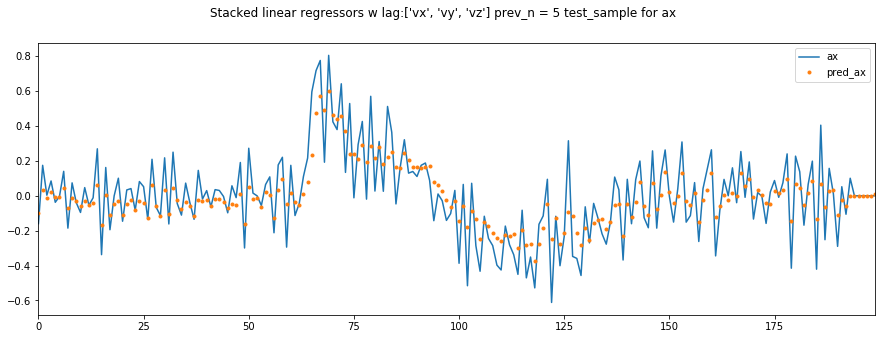

In [21]:
import matplotlib.pyplot as plt

sub_test = test.loc[:199]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ax', 'pred_ax']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Stacked linear regressors w lag:['vx', 'vy', 'vz'] prev_n = 5 test_sample for ax")

#### Ay

In [22]:
test['pred_ay_base'] = y_pred_XGB_ay

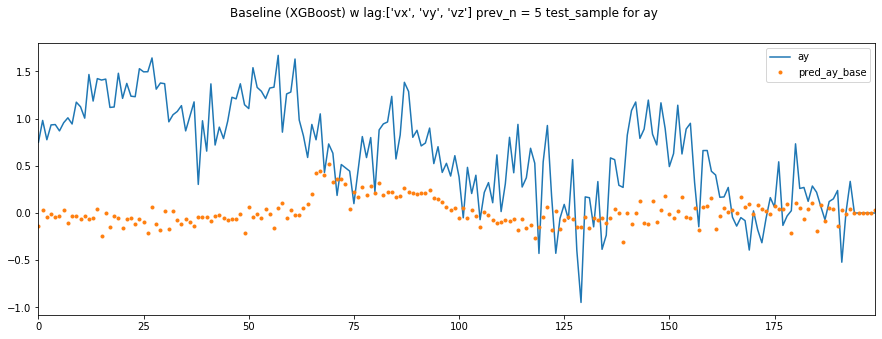

In [23]:
import matplotlib.pyplot as plt

sub_test = test.loc[:199]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ay', 'pred_ay_base']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline (XGBoost) w lag:['vx', 'vy', 'vz'] prev_n = 5 test_sample for ay")

In [28]:
test['pred_ay'] = y_pred_SR_ay

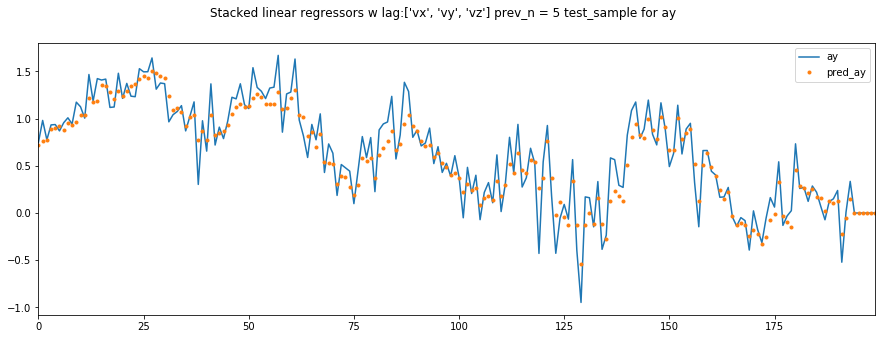

In [29]:
import matplotlib.pyplot as plt

sub_test = test.loc[:199]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ay', 'pred_ay']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Stacked linear regressors w lag:['vx', 'vy', 'vz'] prev_n = 5 test_sample for ay")

In [30]:
test_predictions = test.loc[:,['ax','pred_ax_base','pred_ax','ay','pred_ay_base','pred_ay']]

In [31]:
test_predictions.to_csv('test_predictions_shuffled.csv',index = False)